<a href="https://colab.research.google.com/github/Brymer-Meneses/PyTorch-Basics/blob/master/PyTorch_CvD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.autograd import Variable


import pandas as pd
import os
from zipfile import ZipFile
from skimage import io

import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/External Datasets/Kaggle"

In [3]:
!kaggle competitions download -c dogs-vs-cats

 97% 529M/543M [00:07<00:00, 90.5MB/s]
100% 543M/543M [00:07<00:00, 71.2MB/s]
 98% 265M/271M [00:05<00:00, 67.1MB/s]
100% 271M/271M [00:05<00:00, 50.5MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 89.6MB/s]


In [4]:
zip_path = '/content/train.zip'

zip = ZipFile(zip_path, 'r')
zip.extractall()

In [5]:
data = os.listdir('/content/train')
ds = pd.DataFrame()
ds['file'] = data

In [6]:
def classify(img):
  if img.split('.')[0] == 'dog':
    return 1
  elif img.split('.')[0] == 'cat':
    return 0

In [7]:
ds['target'] = list(map(classify, ds['file']))

In [8]:
ds.to_csv(r'/content/train.csv', index = False, header = False)

In [9]:
# DataLoader

class CatsAndDogsDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform = None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations) 
  
  def __getitem__(self, index):
   
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

    if self.transform:
      image = self.transform(image)
    
    return (image, y_label)


In [10]:
T = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(255),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

In [11]:


dataset = CatsAndDogsDataset(csv_file = '/content/train.csv',
                             root_dir = '/content/train', 
                             transform = T
                            )

In [12]:
def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title == 1:
      plt.title("dog")
    else:
      plt.title('cat')
    plt.show()


In [13]:
dataiter = iter(dataset)

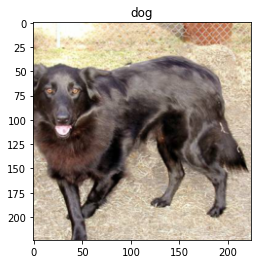

In [22]:
img, label = next(dataiter)
imshow(img, label)

In [21]:
print(img.shape)

torch.Size([3, 224, 224])


In [19]:
train_set , test_set = torch.utils.data.random_split(dataset, [20000, 4999])

In [20]:
train_loader = DataLoader(dataset = train_set, batch_size = 64, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = 64, shuffle = False)

# Create Neural Network

In [ ]:
# nn_out = floor((n_in + 2p - k)/s) + 1

In [95]:
# image size = 224 x 224

class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3,       # 224 x 224 -> 222 x 222
                           out_channels = 64,
                           kernel_size = 3)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)   # 222 x 222 -> 111 x 111
    self.batchnorm1 = nn.BatchNorm2d(64)
    self.dropout1 = nn.Dropout(p = 0.5)

    self.conv2 = nn.Conv2d(in_channels = 64,         # 111 x 111 -> 106 x 106
                           out_channels = 128,
                           kernel_size = 5)
    self.maxpool2 = nn.MaxPool2d(kernel_size = 2)  # 106 x 106 -> 53 x 53
    self.batchnorm2 = nn.BatchNorm2d(128)
    self.dropout2 = nn.Dropout(p = 0.3)

    self.conv3 = nn.Conv2d(in_channels = 128,     # 53 x 53 -> 46 x 46
                           out_channels = 256,
                           kernel_size = 7)
    self.maxpool3 = nn.MaxPool2d(kernel_size=2)  # 46 x 46 -> 23 x 23
    self.batchnorm3 = nn.BatchNorm2d(256)
    self.dropout3 = nn.Dropout(p = 0.2)

    self.fc1 = nn.Linear(256*23*23, 1000)
    self.dropout4 = nn.Dropout(p = 0.1)

    self.fc2 = nn.Linear(1000, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.maxpool1(x)
    x = self.batchnorm1(x)
    x = self.dropout1(x)
   

    x = self.conv2(x)
    x = F.relu(x)
    x = self.maxpool2(x)
    x = self.batchnorm2(x)
    x = self.dropout2(x)
   

    x = self.conv3(x)
    x = F.relu(x)
    x = self.maxpool3(x)
    x = self.batchnorm3(x)
    x = self.dropout3(x)
    

    print(x.shape)
    x = x.reshape(x.size(0), -1)
    print(x.shape)

    x = self.fc1(x)
    x = self.dropout4(x)
    x = F.relu(x)
    x = self.fc2
    print(x.shape)
    return x


In [96]:
model = ConvNet()

In [97]:
model

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=135424, out_features=1000, bias=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (fc2)

In [98]:
# HyperParameters
n_epochs = 10
lr = 0.001


In [99]:

cec_loss = nn.CrossEntropyLoss()
params = model.parameters()
optimizer = optim.Adam(params = params, lr = 0.001)

n_epochs = 3
n_iterations = 0

In [100]:
losses = []
model.train()
for e in range(n_epochs):
  counter = 0
  for i, (images, labels) in enumerate(train_loader):
    images = Variable(images)
    labels = Variable(labels)
    output = model(images)

    model.zero_grad()
    loss = cec_loss(output, labels)
    loss.backward()

    optimizer.step()
    n_iterations +=1 
    counter += 1

    if counter % 100 == 0:
      print(loss.item())

torch.Size([64, 256, 23, 23])
torch.Size([64, 135424])


ModuleAttributeError: ignored